In [1]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import cv2
import numpy as np
from skimage import io, transform
import torch.nn as nn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch.optim as optim
import torch.backends.cudnn as cudnn
import time
from progress.bar import Bar
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import torch.nn.functional as F


In [10]:
class HandKeypointDataset(Dataset):
    """OpenPose Hand Landmarks dataset."""
    
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.landmark_paths = [i for i in os.listdir(self.root) if i.endswith(".json")]
        self.img_paths = [i[0:-5]+".jpg" for i in self.landmark_paths]
        
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = os.path.join(self.root, self.img_paths[idx])
        image = io.imread(img_path)/255.0
        
        landmark_path = os.path.join(self.root, self.landmark_paths[idx])
        landmark_data = json.load(open(landmark_path, 'r'))
        landmark_points = np.array(landmark_data['hand_pts'])[:,:2]
        landmarks = landmark_points.astype('float')
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [11]:
hand_keypoint_dataset = HandKeypointDataset(root="../datasets/KeypointDataset/")

In [12]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

0 (1024, 1024, 3) (21, 2)
1 (368, 368, 3) (21, 2)
2 (368, 368, 3) (21, 2)
3 (368, 368, 3) (21, 2)


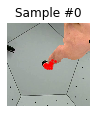

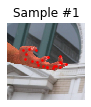

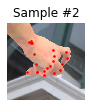

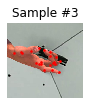

In [13]:
fig = plt.figure()

for i in range(len(hand_keypoint_dataset)):
    sample = hand_keypoint_dataset[i]

    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break

In [14]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        
        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}
    

class ModifiedNormalize(object):
    """Normalize ndarrays in sample, keep labels as same."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = transforms.functional.normalize(image, mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225)).float()
        landmarks = landmarks.float()
        return {'image': image,
                'landmarks': landmarks}

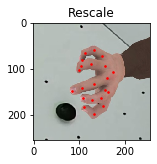

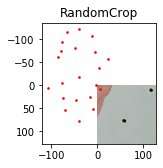

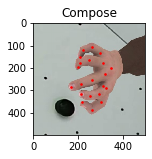

In [15]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(512),
                               RandomCrop(500)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = hand_keypoint_dataset[35]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

In [17]:
hand_keypoint_dataset = HandKeypointDataset(root="../datasets/KeypointDataset/", 
                                            transform=transforms.Compose([Rescale((512,512)),
                                                                          ToTensor(),
                                                                          ModifiedNormalize()
                                                                          ]))

for i in range(len(hand_keypoint_dataset)):
    sample = hand_keypoint_dataset[i]

    print(i, sample['image'].size(), sample['landmarks'].size())
    if i == 3:
        break

0 torch.Size([3, 512, 512]) torch.Size([21, 2])
tensor([[[0.3652, 0.3652, 0.3652,  ..., 1.6811, 1.6131, 1.1548],
         [0.3652, 0.3652, 0.3652,  ..., 2.1548, 2.0928, 1.6196],
         [0.3652, 0.3652, 0.3652,  ..., 2.2238, 2.1629, 1.7199],
         ...,
         [0.5536, 0.5536, 0.5527,  ..., 0.5364, 0.5364, 0.5364],
         [0.5536, 0.5536, 0.5488,  ..., 0.5364, 0.5364, 0.5364],
         [0.5536, 0.5536, 0.5484,  ..., 0.5364, 0.5364, 0.5364]],

        [[0.6779, 0.6779, 0.6779,  ..., 1.0504, 1.1000, 1.0252],
         [0.6779, 0.6779, 0.6779,  ..., 1.1422, 1.1910, 1.1127],
         [0.6779, 0.6779, 0.6779,  ..., 1.0999, 1.1600, 1.0830],
         ...,
         [0.8529, 0.8529, 0.8521,  ..., 0.8529, 0.8529, 0.8529],
         [0.8529, 0.8529, 0.8481,  ..., 0.8529, 0.8529, 0.8529],
         [0.8529, 0.8529, 0.8477,  ..., 0.8529, 0.8529, 0.8529]],

        [[0.7576, 0.7576, 0.7576,  ..., 0.7421, 0.8101, 0.7893],
         [0.7576, 0.7576, 0.7576,  ..., 0.8076, 0.8694, 0.8565],
         [

In [10]:
dataloader = DataLoader(hand_keypoint_dataset, batch_size=8, shuffle=True, num_workers=0)


0 torch.Size([8, 3, 512, 512]) torch.Size([8, 21, 2])
1 torch.Size([8, 3, 512, 512]) torch.Size([8, 21, 2])
2 torch.Size([8, 3, 512, 512]) torch.Size([8, 21, 2])
3 torch.Size([8, 3, 512, 512]) torch.Size([8, 21, 2])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


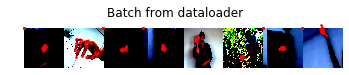

In [11]:
# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size,
                    landmarks_batch[i, :, 1].numpy() + grid_border_size,
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

In [12]:
class KeyNet(nn.Module):
    def __init__(self,num_classes):
        super(KeyNet, self).__init__()
        self.net = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=True)
        self.in_features = self.net.roi_heads.box_predictor.cls_score.in_features
        self.net.roi_heads.box_predictor = FastRCNNPredictor(self.in_features, num_classes)
    def forward(self,x):
        x = self.net(x)
        x = self.pooling(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [13]:
use_cuda = torch.cuda.is_available()
use_cuda

True

In [14]:
model = KeyNet(21)
model

KeyNet(
  (net): KeypointRCNN(
    (transform): GeneralizedRCNNTransform(
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        Resize(min_size=(640, 672, 704, 736, 768, 800), max_size=1333, mode='bilinear')
    )
    (backbone): BackboneWithFPN(
      (body): IntermediateLayerGetter(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): FrozenBatchNorm2d()
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): FrozenBatchNorm2d()
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): FrozenBatchNorm2d()
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn3): FrozenBat

In [15]:
# model(hand_keypoint_dataset[0]['image'])

In [16]:
#model = torch.nn.DataParallel(model).cuda()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.MSELoss().to(device=device)
optimizer = optim.Adam(params=model.parameters(),lr=0.0001, weight_decay=0.00005)

In [17]:
# for i in range(100):
#     for b, train_f in enumerate(dataloader):
#         y_pred = model(train_f['image'], train_f['landmarks'])
#         break
        

In [18]:
model_rcnn = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=True)


In [19]:

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 6*6 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 42)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
            size = x.size()[1:]  # all dimensions except the batch dimension
            num_features = 1
            for s in size:
                num_features *= s
            return num_features

In [20]:
net = Net()


In [21]:
# for i in range(100):
#     for b, train_f in enumerate(dataloader):
#         y_pred = net(train_f['image'].float())
#         break

In [40]:
class SqueezeNet(nn.Module):
    def __init__(self,num_classes):
        super(SqueezeNet,self).__init__()
        self.pretrain_net = torchvision.models.squeezenet1_1(pretrained=True)
        self.base_net = self.pretrain_net.features
        self.conv1  = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=2)
        self.conv2  = nn.Conv2d(in_channels=256, out_channels=32, kernel_size=3, stride=2)
        self.conv3  = nn.Conv2d(in_channels=32, out_channels=num_classes, kernel_size=3, stride=3)
        self.pooling  = nn.MaxPool2d((1,2))
    def forward(self,x):
        x = self.base_net(x)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pooling(x)
        x = x.squeeze(3)
        return x


In [41]:
smodel = SqueezeNet(21).to(device)
print(device)
# smodel = torch.nn.DataParallel(smodel).cuda()


cuda:0


In [42]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.MSELoss().to(device=device)
optimizer = optim.Adam(params=smodel.parameters(),lr=0.0001, weight_decay=0.00005)


In [5]:
def dist_loss(a,b):
    dist = torch.pairwise_distance(a,b)
    print(dist)
    total_dist = torch.sum(dist)
    return total_dist

In [44]:
torch.cuda.empty_cache()

In [45]:
train_losses = []
test_losses = []
train_correct = []
test_correct = []

print('Started Training')
for epoch in range(50):
    running_loss = 0.0
    
    # Run the training batches
    for b, train_f in enumerate(dataloader):
        y_train = train_f['landmarks'].to(device)
        x_train = train_f['image'].to(device)
        
        
        # Apply the model
        y_pred = smodel(x_train)
        loss = dist_loss(y_pred, y_train)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        # Print interim results
        if b % 200 == 199:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, b + 1, running_loss / 2000))
            running_loss = 0.0
    
    print('Epoch End Loss:',running_loss)

Started Training


KeyboardInterrupt: 

In [97]:
def dist_loss(a,b):
    all_dist = torch.Tensor()
    for i,j in zip(a,b):
        all_dist += torch.pairwise_distance(i,j)
    return all_dist.sum()

In [98]:
import torch
a = torch.randn(8,21,2) * 100
b = torch.randn(8,21,2) * 100

print(a.shape)

torch.Size([8, 21, 2])


In [99]:
dist_loss(a,b)

RuntimeError: The size of tensor a (0) must match the size of tensor b (21) at non-singleton dimension 0

In [58]:
def pairwise_distances(x, y=None):
    '''
    Input: x is a Nxd matrix
           y is an optional Mxd matirx
    Output: dist is a NxM matrix where dist[i,j] is the square norm between x[i,:] and y[j,:]
            if y is not given then use 'y=x'.
    i.e. dist[i,j] = ||x[i,:]-y[j,:]||^2
    '''
    x_norm = (x**2).sum(1).view(-1, 1)
    if y is not None:
        y_norm = (y**2).sum(1).view(1, -1)
    else:
        y = x
        y_norm = x_norm.view(1, -1)

    dist = x_norm + y_norm - 2.0 * torch.mm(x, torch.transpose(y, 0, 1))
    return dist

In [59]:
pairwise_distances(a,b)

RuntimeError: matrices expected, got 3D, 3D tensors at C:\w\b\windows\pytorch\aten\src\TH/generic/THTensorMath.cpp:36